# Implementing uncertainty associated with f-factor estimations to summarize data using the Kent distribution

## Import scientific Python packages

In [1]:
import numpy as np
import pandas as pd

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib

import cartopy.crs as ccrs
import numpy.ma as ma

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [27]:
def bin_trace(lon_samples, lat_samples, resolution):
    """
    Given a trace of samples in longitude and latitude, bin them
    in latitude and longitude, and normalize the bins so that
    the integral of probability density over the sphere is one.

    The resolution keyword gives the number of divisions in latitude.
    The divisions in longitude is twice that.
    """
    lats = np.linspace(-90., 90., resolution, endpoint=True)
    lons = np.linspace(-180., 180., 2 * resolution, endpoint=True)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    hist = np.zeros_like(lon_grid)

    dlon = 360. / (2. * resolution)
    dlat = 180. / resolution

    for lon, lat in zip(lon_samples, lat_samples):

        lon = np.mod(lon, 360.)
        if lon > 180.:
            lon = lon - 360.
        if lat < -90. or lat > 90.:
            # Just skip invalid latitudes if they happen to arise
            continue

        lon_index = int(np.floor((lon + 180.) / dlon))
        lat_index = int(np.floor((lat + 90.) / dlat))
        hist[lat_index, lon_index] += 1

    lat_grid += dlat / 2.
    lon_grid += dlon / 2.
    return lon_grid, lat_grid, hist


def density_distribution(lon_samples, lat_samples, resolution=30):
    count = len(lon_samples)
    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)
    return lon_grid, lat_grid, hist / count


def cumulative_density_distribution(lon_samples, lat_samples, resolution=30):

    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)

    # Compute the cumulative density
    hist = hist.ravel()
    i_sort = np.argsort(hist)[::-1]
    i_unsort = np.argsort(i_sort)
    hist_cumsum = hist[i_sort].cumsum()
    hist_cumsum /= hist_cumsum[-1]

    return lon_grid, lat_grid, hist_cumsum[i_unsort].reshape(lat_grid.shape)


def plot_distributions(ax, lon_samples, lat_samples, to_plot='d', resolution=100, **kwargs):

    cmap=kwargs.get('cmap', 'viridis')

    artists = []

    if 'd' in to_plot:
        lon_grid, lat_grid, density = density_distribution(
            lon_samples, lat_samples, resolution)
        density = ma.masked_where(density <= 0.05*density.max(), density)
        a = ax.pcolormesh(lon_grid, lat_grid, density, cmap=cmap,
                          transform=ccrs.PlateCarree())
        artists.append(a)

    if 'e' in to_plot:
        lon_grid, lat_grid, cumulative_density = cumulative_density_distribution(
            lon_samples, lat_samples, resolution)
        a = ax.contour(lon_grid, lat_grid, cumulative_density, levels=[
                       0.95], cmap=cmap, transform=ccrs.PlateCarree(), lw=kwargs.get('lw', 1))
        artists.append(a)

    if 's' in to_plot:
        a = ax.scatter(lon_samples, lat_samples, color=kwargs.get('color', 'C0'), alpha=0.1, transform=ccrs.PlateCarree(), edgecolors=None, **kwargs)
        artists.append(a)

    return artists

## Import data and filter by component

In [3]:
Cutface_specimens = pd.read_csv('../../data/Pmag/cutface/specimens.txt', sep='\t', header=1)

Cutface_lat = 47.73055
Cutface_lon = -90.44128

Cutface_specimens['slat'] = Cutface_lat
Cutface_specimens['slon'] = Cutface_lon

In [4]:
specimens_mt_geo = Cutface_specimens[(Cutface_specimens['dir_comp']=='mt') & (Cutface_specimens['dir_tilt_correction']==0)]
specimens_mt_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='mt') & (Cutface_specimens['dir_tilt_correction']==100)]

specimens_ht_geo = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==0)]
specimens_ht_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==100)]
specimens_ht_tc['plon'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[0]
specimens_ht_tc['plat'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[1]

In [5]:
# filter out the only negative inclination data
#specimens_ht_tc=specimens_ht_tc[specimens_ht_tc['dir_inc']>0]

In [6]:
mean_mt = ipmag.fisher_mean(specimens_mt_tc['dir_dec'].tolist(),specimens_mt_tc['dir_inc'].tolist())
mean_ht = ipmag.fisher_mean(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist())

## mt component directions

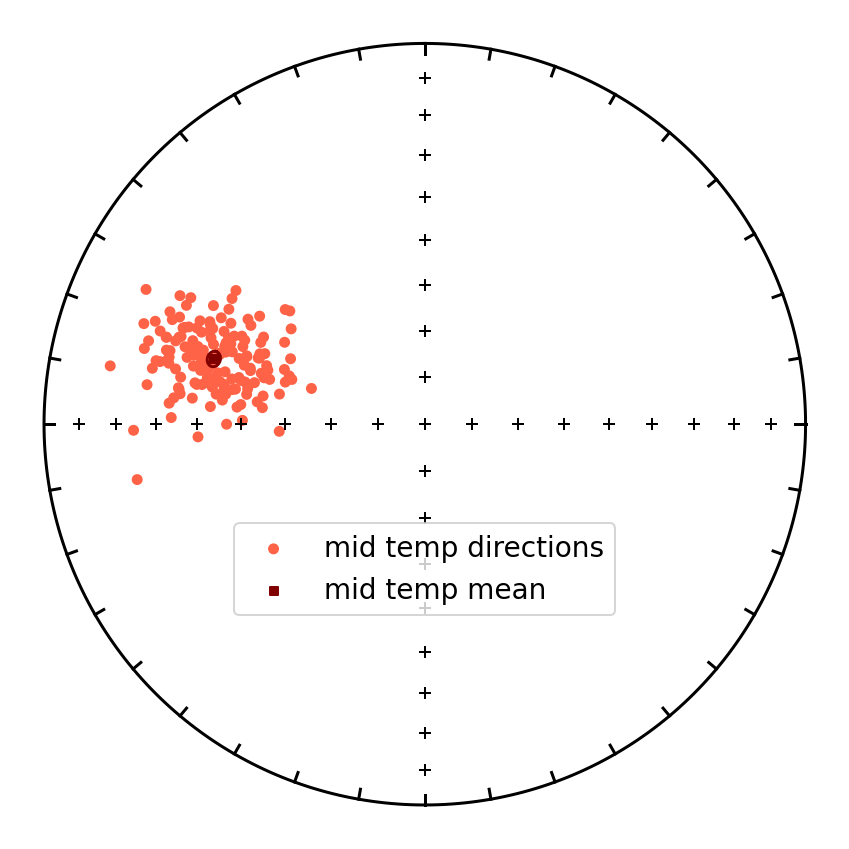

In [7]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(specimens_mt_tc['dir_dec'].tolist(),specimens_mt_tc['dir_inc'].tolist(),color='tomato',label='mid temp directions')

ipmag.plot_di_mean(mean_mt['dec'],mean_mt['inc'],mean_mt['alpha95'],
                    color='maroon', marker = 's', label='mid temp mean')

plt.legend(loc=8,bbox_to_anchor=(0.50,0.25),fontsize=14)
plt.show()

## ht component directions

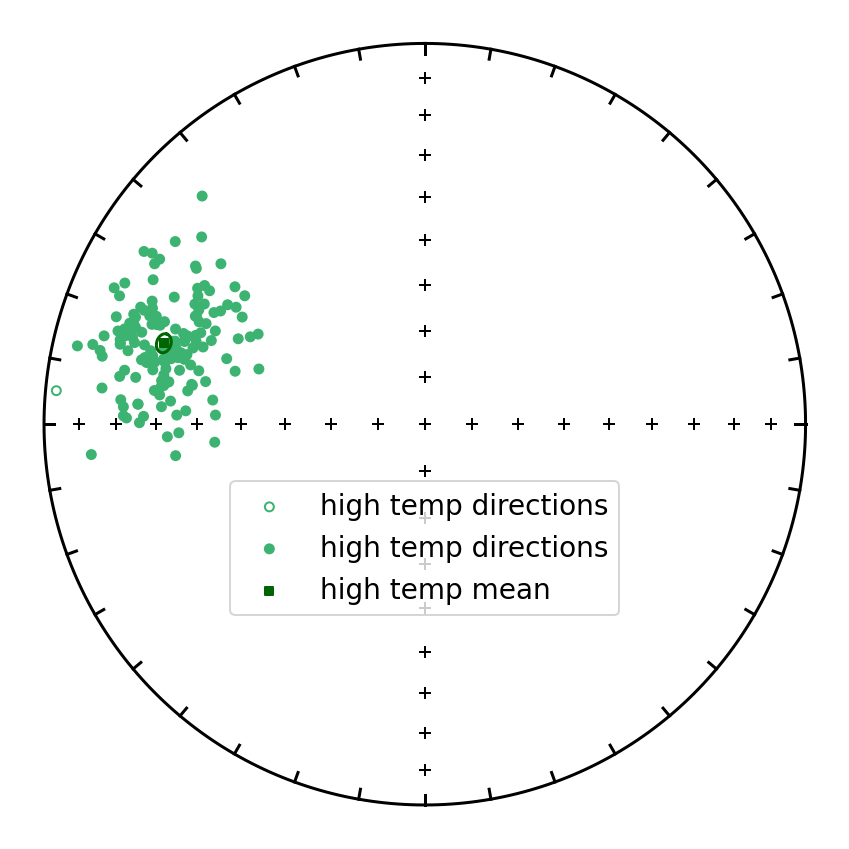

In [8]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist(),color='mediumseagreen',label='high temp directions')

ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='darkgreen', marker = 's', label='high temp mean')

plt.legend(loc=8,bbox_to_anchor=(0.50,0.25),fontsize=14)
plt.show()

## mid temp (CRM) and high temp (DRM) directions compared to NSVG direction mean

In [9]:
NSVG_pole_lat = 31.1 
NSVG_pole_lon = 181.7
NSVG_A95 = 4.2

NSVG_dec, NSVG_inc = pmag.vgp_di(NSVG_pole_lat,NSVG_pole_lon,Cutface_lat, Cutface_lon)

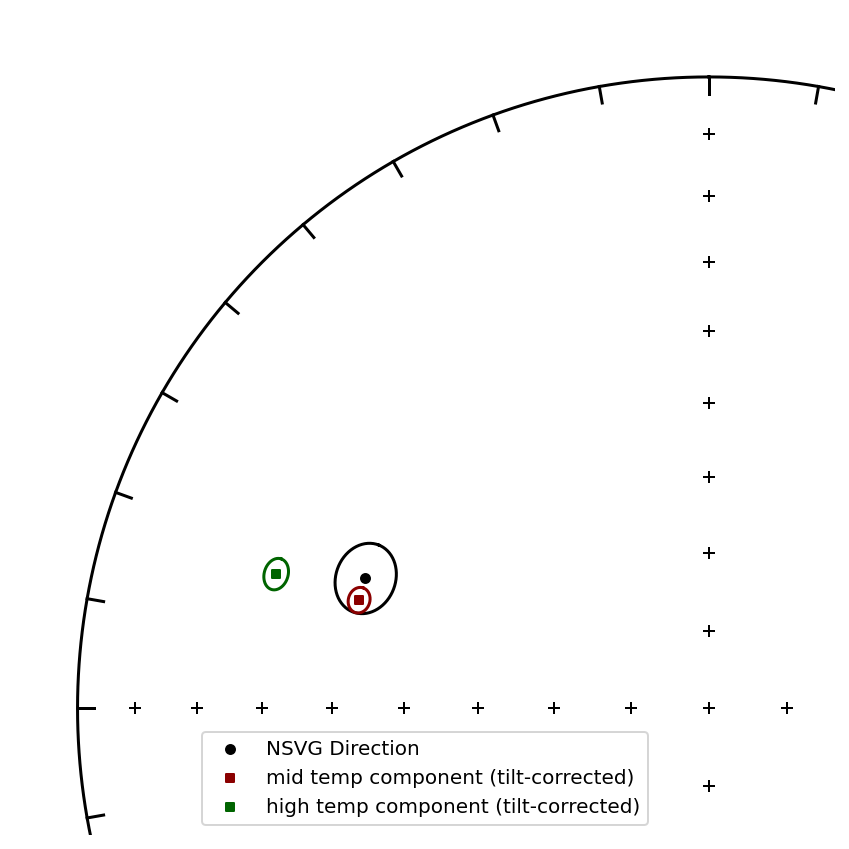

In [10]:
cf_igrf_nsvg_stereonet=plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di_mean(NSVG_dec, NSVG_inc, NSVG_A95, label='NSVG Direction') #need to replace with direction A95

ipmag.plot_di_mean(mean_mt['dec'],mean_mt['inc'],mean_mt['alpha95'],
                   color='darkred', marker = 's', label='mid temp component (tilt-corrected)')
ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='darkgreen', marker = 's', label='high temp component (tilt-corrected)')

plt.xlim(-.7, -0.2)
plt.ylim(-0.2,1.1)
plt.legend(loc=8)
plt.show()

Bootstrapping.... be patient

The original inclination was: 29.04

The corrected inclination is: 38.52
with bootstrapped confidence bounds of: 32.36 to 44.55
and elongation parameter of: 2.0
The flattening factor is: 0.68
with bootstrapped confidence bounds of: 0.88 to 0.56


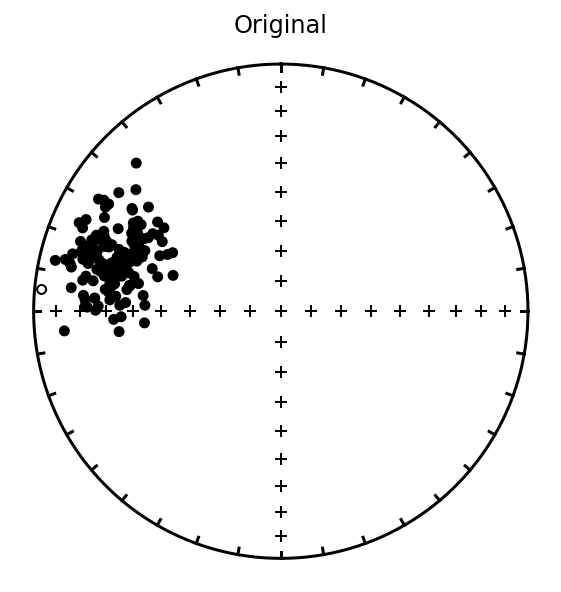

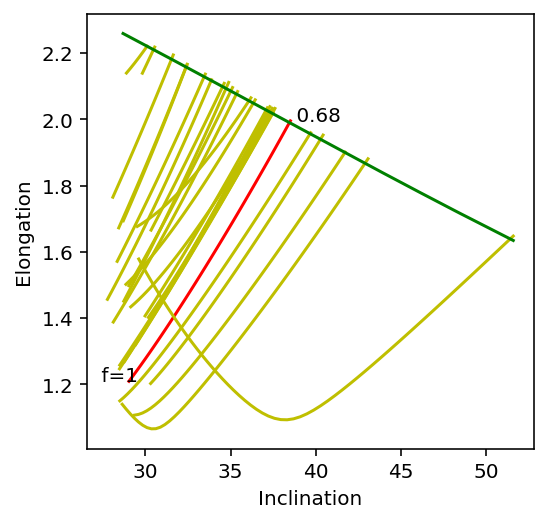

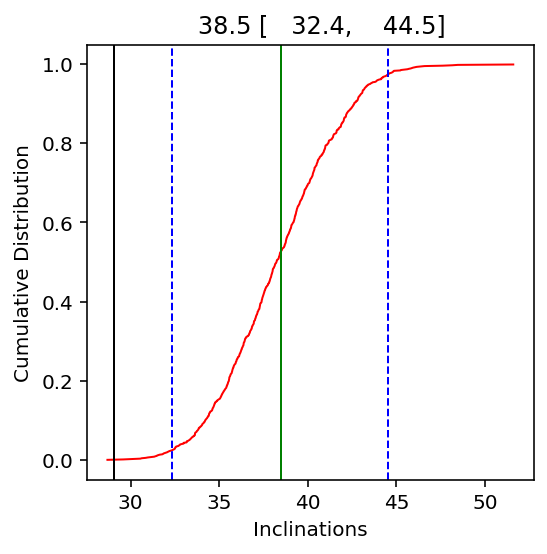

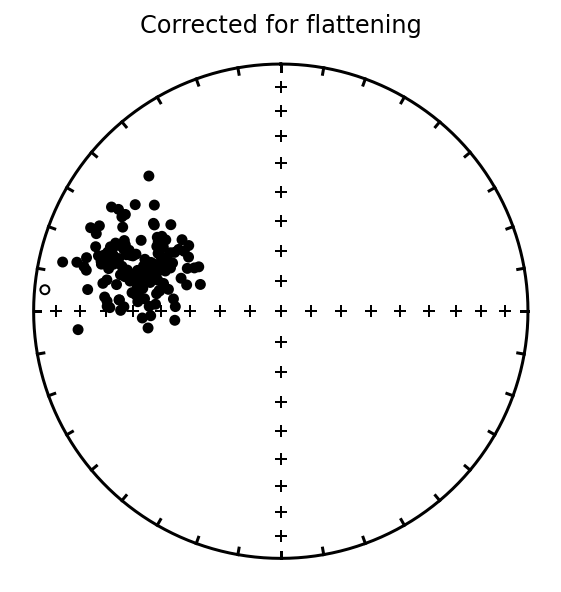

In [11]:
EI_incs, EI_elongs, EI_fs = ipmag.find_ei(specimens_ht_tc[['dir_dec', 'dir_inc']].to_numpy(), nb=1000, return_values = True)

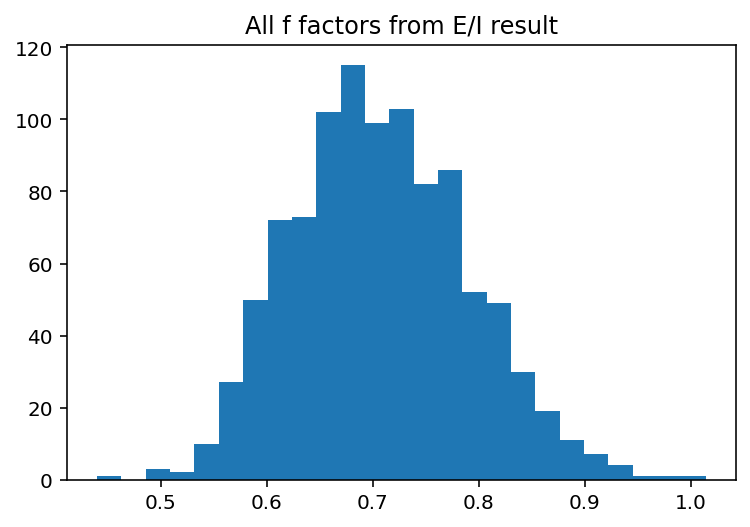

In [12]:
plt.hist(EI_fs, bins=25)
plt.title('All f factors from E/I result')
plt.show()

### show all unsquished directions according to E/I bootstrap results

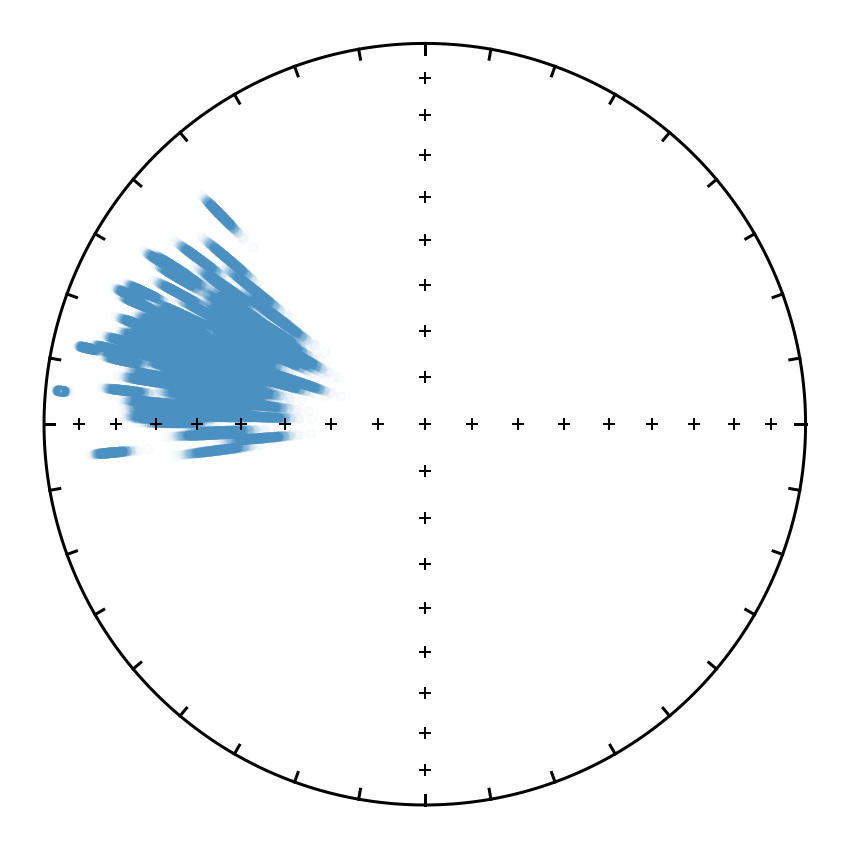

In [13]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()

plt.figure(figsize=(6,6))
ipmag.plot_net()
for f in EI_fs:
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    ipmag.plot_di(specimens_ht_tc_decs, unsquish_incs, color = 'C0', alpha=0.02)

<Figure size 576x576 with 0 Axes>

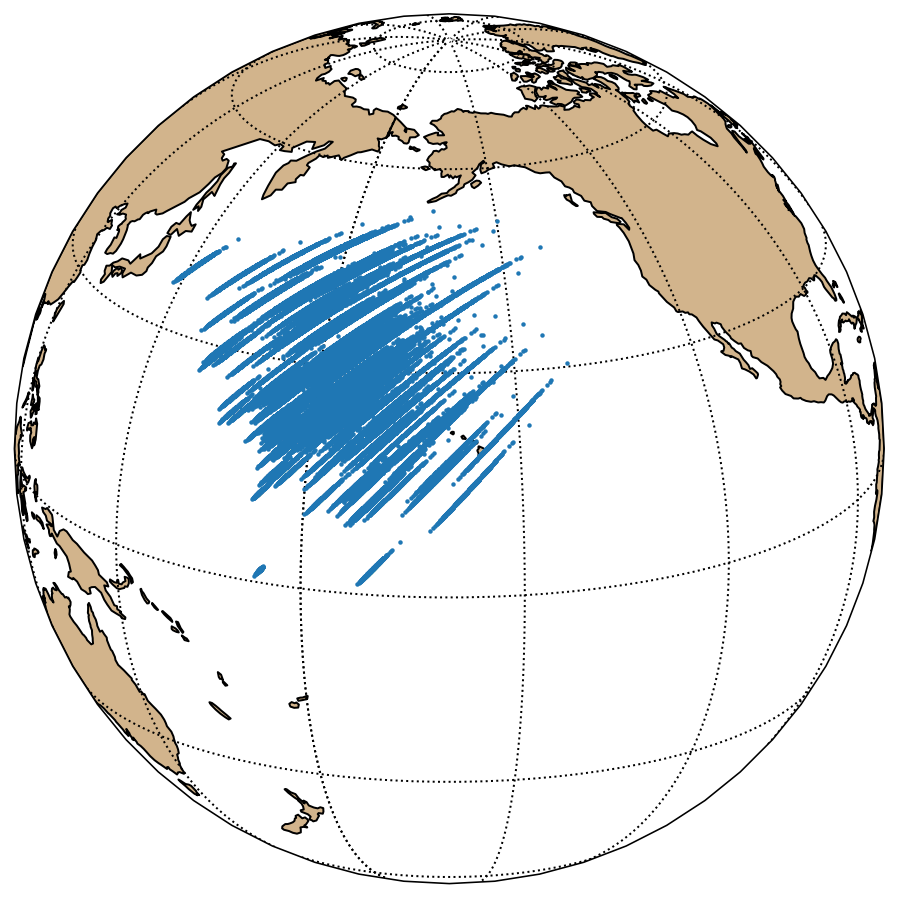

In [14]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
for f in EI_fs:
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    ipmag.plot_vgp(m, unsquish_lons, unsquish_lats, color = 'C0', edge='none', markersize=5)
plt.show()

<Figure size 576x576 with 0 Axes>

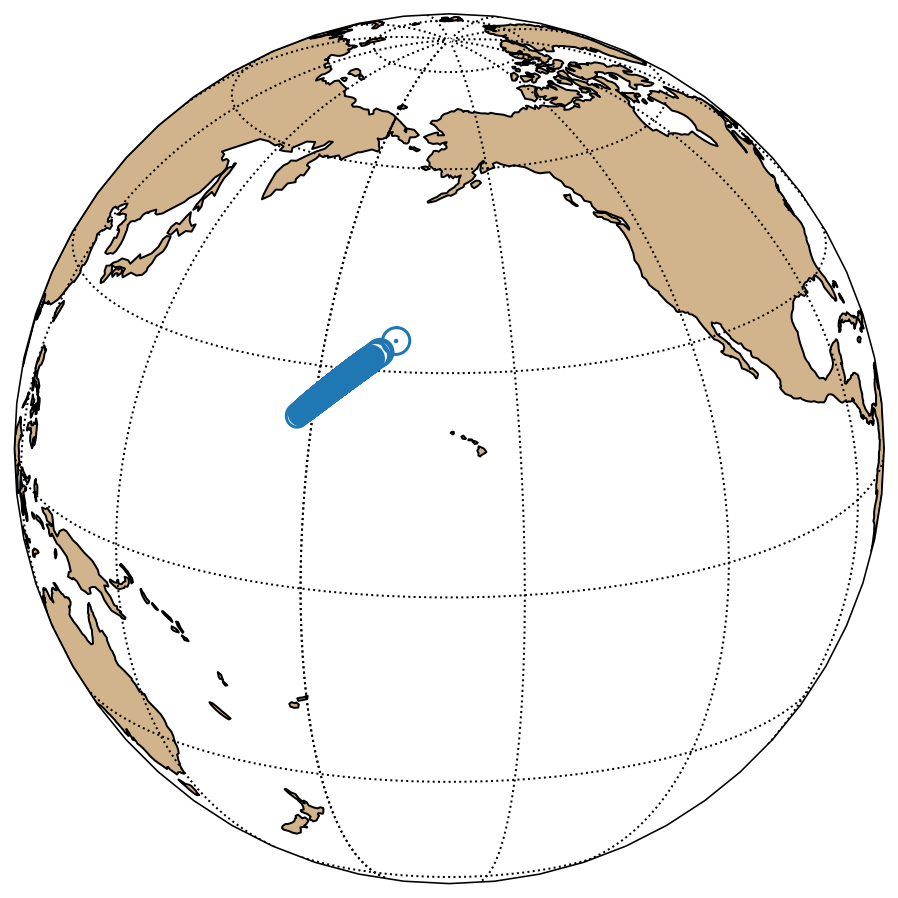

In [15]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
for f in EI_fs:
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    ipmag.plot_pole(m, unsquish_VGPs_mean['dec'], unsquish_VGPs_mean['inc'], unsquish_VGPs_mean['alpha95'], 
                    color='C0', edgecolor='none', markersize=5)
plt.show()

<Figure size 576x576 with 0 Axes>

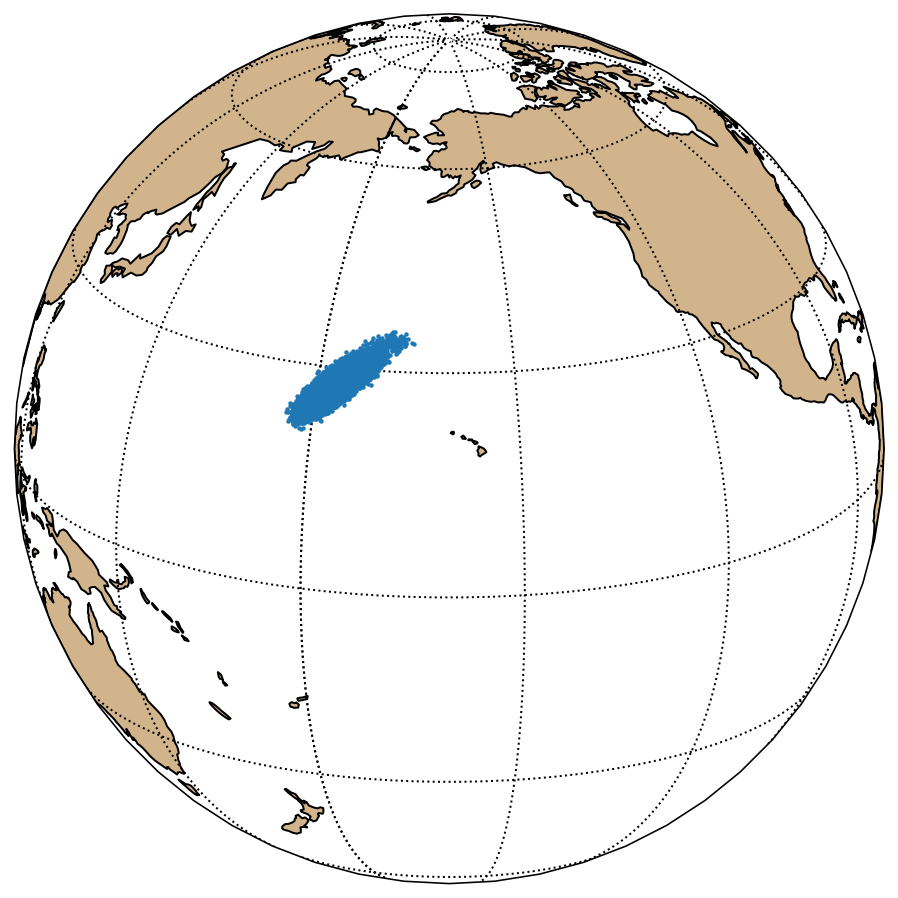

In [16]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

mean_lons = []
mean_lats = []

for f in EI_fs:
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    resampled_lons, resampled_lats = ipmag.fisher_mean_resample(alpha95=unsquish_VGPs_mean['alpha95'], n=100, 
                                                   dec=unsquish_VGPs_mean['dec'], inc=unsquish_VGPs_mean['inc'], di_block=0)
    mean_lons.extend(resampled_lons)
    mean_lats.extend(resampled_lats)

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_vgp(m, mean_lons, mean_lats, color='C0', edge='none', markersize=5)

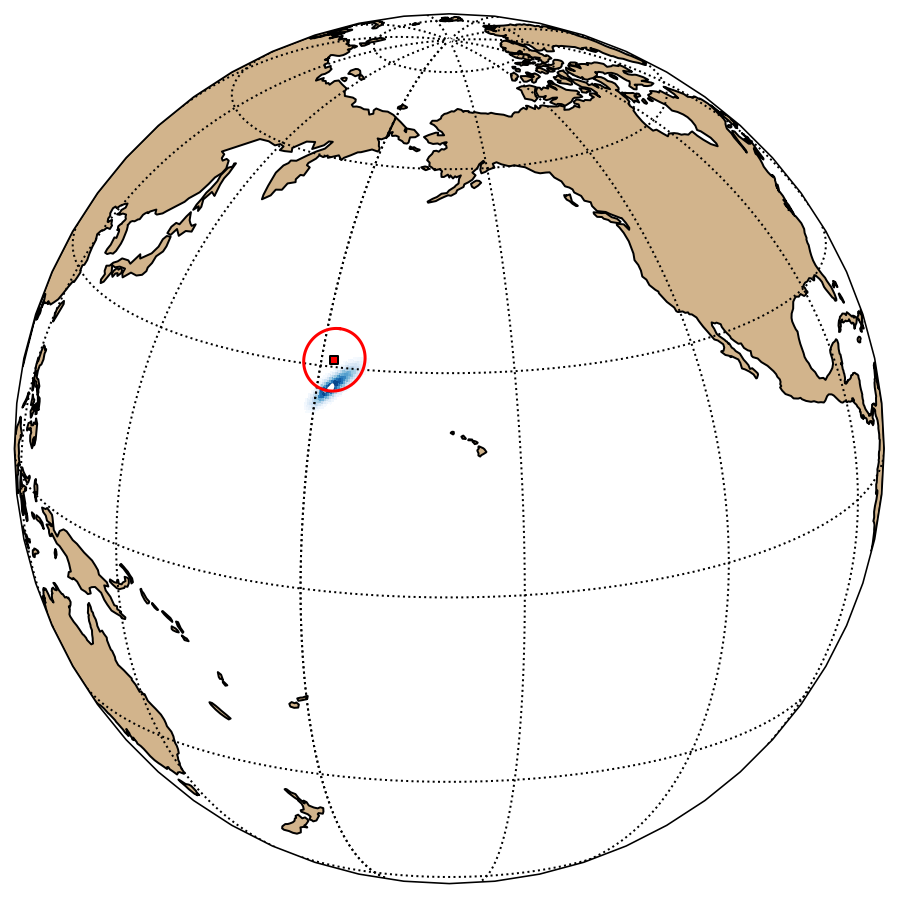

In [17]:
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_pole(m,182,31,4.2,label='North Shore Volcanic Group (upper NE)',marker='s',color='Red')
#plot_distributions(m, mean_lons, mean_lats, to_plot='s', resolution = 500)
plot_distributions(m, mean_lons, mean_lats, to_plot='d', resolution = 500, cmap='Blues')
plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 500, cmap='Greys')
# m.legend()

In [18]:
kent_distribution_95 = ipmag.kent_distribution_95(dec=mean_lons,inc=mean_lats) 

<GeoAxesSubplot:>

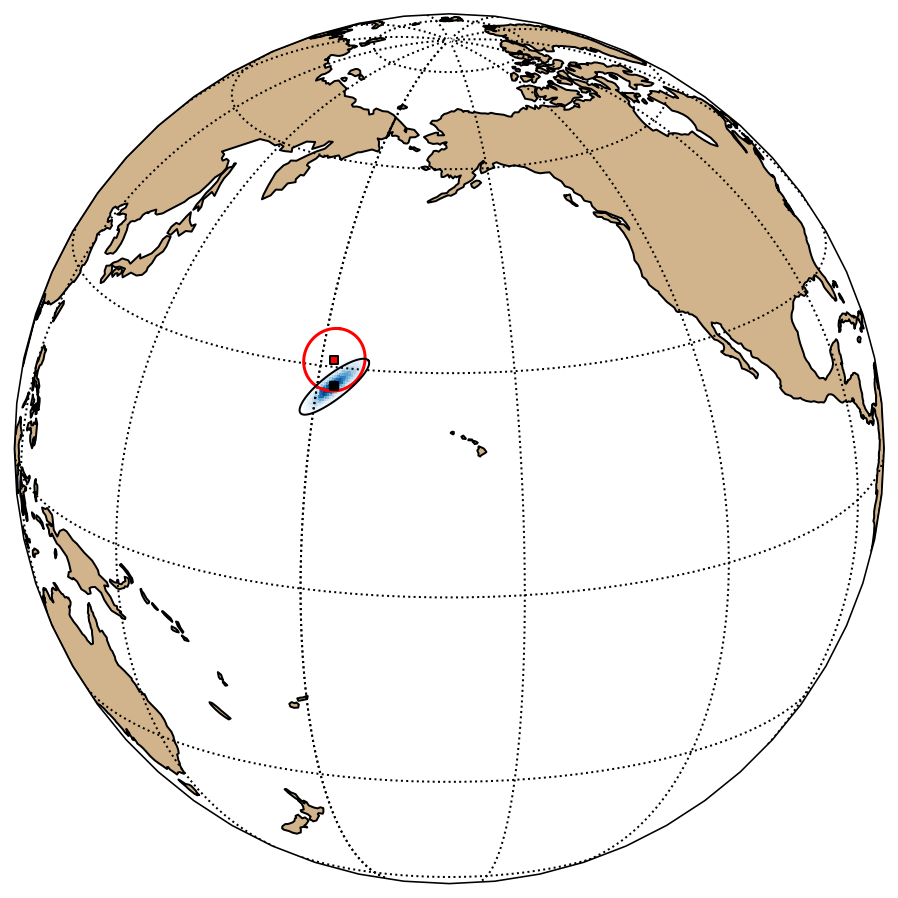

In [19]:
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_pole(m,182,31,4.2,label='North Shore Volcanic Group (upper NE)',marker='s',color='Red')
#plot_distributions(m, mean_lons, mean_lats, to_plot='s', resolution = 500)
plot_distributions(m, mean_lons, mean_lats, to_plot='d', resolution = 500, cmap='Blues')
#plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 500, cmap='Greys')
ipmag.plot_pole_ellipse(m,kent_distribution_95)

<GeoAxesSubplot:>

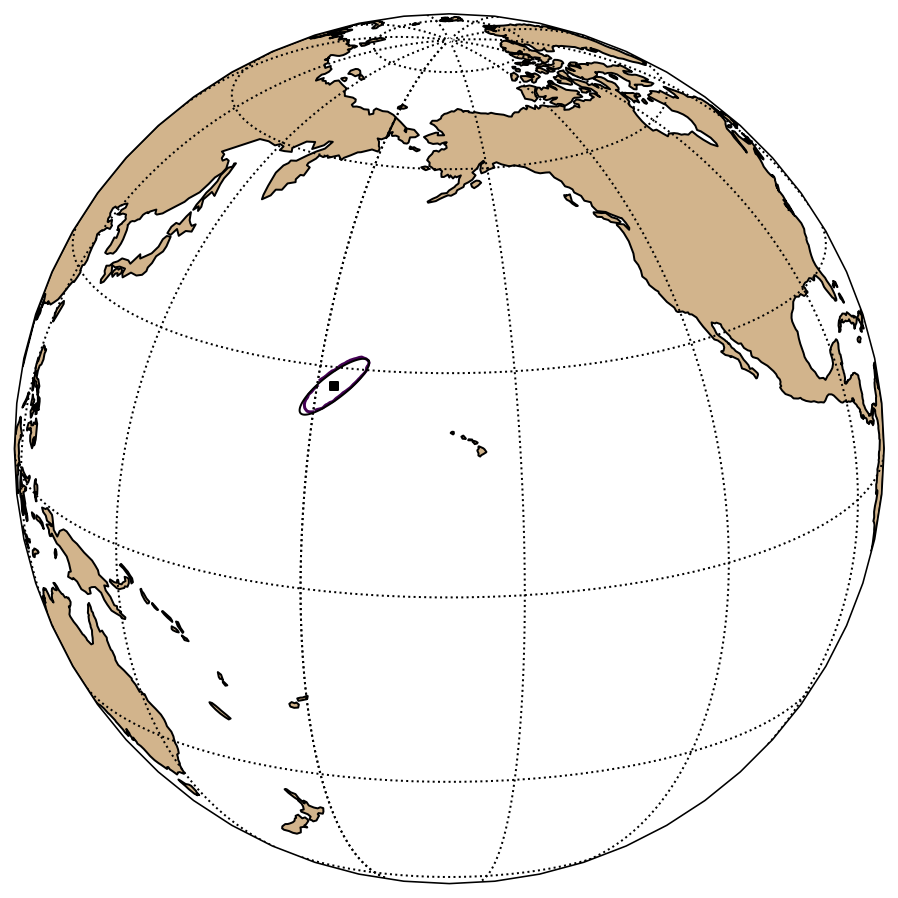

In [30]:
m = ipmag.make_orthographic_map(200, 20)
plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 500, cmap='viridis')
ipmag.plot_pole_ellipse(m,kent_distribution_95)